In [66]:
import pandas as pd
from pandas.tseries.offsets import MonthEnd
from FileOpener.CSVReader.CSVReader import CSVReader as csv
import numpy as np
import matplotlib 

%matplotlib inline

# Bring the file

## Price Data

### 코스피
-- 00.07.01 ~ 18.12.31
### 당기순익(분기)
-- 00.1Q ~ 18.3Q

In [73]:
prc_dir = 'CSVFile/Price/Korea/Stocks'
fin_dir = 'CSVFile/FinancialData/Korea'

price_data = csv.price_reader(filename = 'KOSPI_FROM_1998_close.csv', directory = prc_dir).loc['2000-07-01':'2018-12-31']
fin_data = csv.financial_reader(filename = 'NET_INCOME_KSE.csv', directory = fin_dir)

### 가격 데이터 개괄

In [74]:
print(f"코스피 내 거래종목: {price_data.shape[1]}")
print(f"총 거래일수: {price_data.shape[0]}")

코스피 내 거래종목: 1192
총 거래일수: 4569


### 재무 데이터 개괄

In [75]:
print(f"코스피 내 거래종목: {fin_data.shape[1]}")
print(f"총 분기: {fin_data.shape[0]}")

코스피 내 거래종목: 1192
총 분기: 75


# 데이터 조정

## 재무 데이터 조정
### Look Back Bias 방지를 위해 당분기 데이터를 다음분기 데이터로 조정

In [76]:
net_income = fin_data.shift(1).dropna(axis = 0, how = 'all')

## 당기순익 적자 / 흑자 구분

### 만약 데이터가 NaN 값인 경우는 NaN 값으로 반환 해주어야 함

In [77]:
def plus_to_nan(x):
    
    if x < 0: 
        return False
    elif x >= 0: 
        return True
    else:
        return np.nan

net_income_plus = net_income.applymap(plus_to_nan)

In [78]:
net_income_plus.head()

,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A298050,A298690,A300720,A306200,A900030,A900050,A900140,A950010,A950070,A950100
Code,,,,,,,,,,,,,,,,,,,,,
2000-06-30,True,NaN,True,False,True,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-09-30,False,True,False,False,False,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-12-31,True,True,False,False,True,NaN,True,NaN,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-03-31,False,True,False,False,False,False,True,False,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-06-30,True,True,True,True,True,True,True,False,NaN,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 수익률 산출

### 수익률 계산시 극단값 조정

In [79]:
price_rt = price_data.pct_change().dropna(axis = 0, how = 'all')

In [80]:
((price_rt > 0.3).sum()).sum() 

367

In [81]:
price_rt[price_rt > 0.3] = 0.3

## 주식 유니버스 선정

In [82]:
## Universe
none_invest = net_income_plus.isnull()
plus_invest = net_income_plus == True
minus_invest = (net_income_plus == False) & ~none_invest

## 당기순익 적자

In [85]:
minus_invest.head()

,A000010,A000020,A000030,A000040,A000050,A000060,A000070,A000080,A000090,A000100,...,A298050,A298690,A300720,A306200,A900030,A900050,A900140,A950010,A950070,A950100
Code,,,,,,,,,,,,,,,,,,,,,
2000-06-30,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2000-09-30,True,False,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2000-12-31,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2001-03-31,True,False,True,True,True,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2001-06-30,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False


## 각 분기별 해당 종목 산출

In [86]:
minus_data = {}
date_index = minus_invest.index

for date in date_index:

    minus_data[date] = (minus_invest.loc[date][minus_invest.loc[date] == True]).index

## 해당 종목 동일가중 포트폴리오의 Composit Return 계산

In [87]:
## Quartarly Change

## invest Date
lag_invest_dates = list(minus_data.keys())[1:]
invest_dates = list(minus_data.keys())[:-1]

ret_data = pd.Series()

for cur_date, lag_date in zip(invest_dates, lag_invest_dates):
    
    ret_data = pd.concat([ret_data, (price_rt.loc[cur_date:lag_date][minus_data[cur_date]]).mean(axis = 1, skipna=True)])

## 상폐 종목의 예시

In [56]:
price_rt['A000280'].loc['2001-06-01':'2001-06-07']

D A T E
2001-06-01   -0.473684
2001-06-04   -0.300000
2001-06-05   -0.142857
2001-06-07    0.000000
Name: A000280, dtype: float64

## 성과평가


In [138]:
from pf_anlysis import PfAnalysis as pf

In [139]:
net_minus_rt = pf(ret_data)

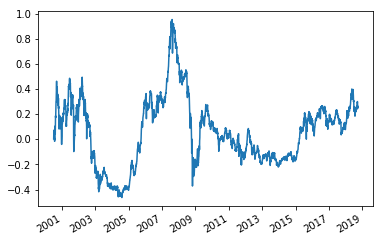

In [128]:
net_minus_rt.cumReturn().sub(1).plot()

In [144]:
net_minus_rt.data.resample('A').prod().sub(1).apply(lambda x: '{:.2%}'.format(x))

2000-12-31     -4.00%
2001-12-31     24.63%
2002-12-31    -39.01%
2003-12-31    -16.01%
2004-12-31     -1.54%
2005-12-31    114.13%
2006-12-31      1.27%
2007-12-31     22.77%
2008-12-31    -51.33%
2009-12-31     42.66%
2010-12-31     -7.88%
2011-12-31    -13.21%
2012-12-31     -8.25%
2013-12-31     -3.04%
2014-12-31      5.75%
2015-12-31     38.57%
2016-12-31     -1.39%
2017-12-31     -4.69%
2018-12-31     15.11%
Freq: A-DEC, dtype: object

In [149]:
print(f"MDD in One Year is {abs(round(net_minus_rt.maxDrawDown()*100, 2))}%")

MDD in One Year is 64.49%


In [161]:
print(f"Total Cummlative Return is {abs(round((net_minus_rt.data.prod() - 1) * 100, 2))}%")

Total Cummlative Return is 25.76%


## 당기순익 흑자 기업

In [151]:
plus_data = {}
date_index = plus_invest.index

for date in date_index:

    plus_data[date] = (plus_invest.loc[date][plus_invest.loc[date] == True]).index

In [152]:
## Quartarly Change

## invest Date
lag_invest_dates = list(plus_data.keys())[1:]
invest_dates = list(plus_data.keys())[:-1]

plus_ret_data = pd.Series()

for cur_date, lag_date in zip(invest_dates, lag_invest_dates):
    
    plus_ret_data = pd.concat([plus_ret_data, (price_rt.loc[cur_date:lag_date][plus_data[cur_date]]).mean(axis = 1)])

In [155]:
net_plus_rt = pf(plus_ret_data)

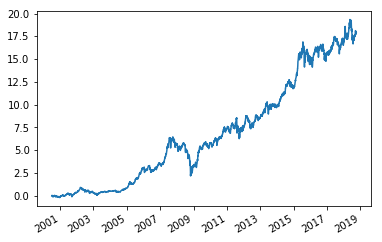

In [156]:
net_plus_rt.cumReturn().sub(1).plot()

In [157]:
(net_plus_rt.data.resample('A').prod().sub(1)).apply(lambda x: '{:.2%}'.format(x))

2000-12-31    -18.68%
2001-12-31     67.01%
2002-12-31     -6.26%
2003-12-31     19.32%
2004-12-31     20.80%
2005-12-31    118.13%
2006-12-31     13.34%
2007-12-31     48.38%
2008-12-31    -37.76%
2009-12-31     61.30%
2010-12-31     24.39%
2011-12-31      0.76%
2012-12-31     13.54%
2013-12-31     13.18%
2014-12-31     18.52%
2015-12-31     26.28%
2016-12-31      1.87%
2017-12-31      7.28%
2018-12-31      6.59%
Freq: A-DEC, dtype: object

In [158]:
print(f"MDD in One Year is {abs(round(net_plus_rt.maxDrawDown()*100, 2))}%")

MDD in One Year is 55.96%
